# Classification

The Palmer Penguins dataset is a common resource for data exploration and demonstration of data analysis techniques. It was brought into the limelight by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, which is a member of the Long Term Ecological Research Network.

The dataset includes data for 344 penguins from three different species found on three islands in the Palmer Archipelago, Antarctica. The measured attributes in the dataset include:

1. **Species**: The species of the penguin, which can be Adelie, Gentoo, or Chinstrap.
2. **Island**: The island in the Palmer Archipelago, Antarctica, where the penguin observation was made. The options are Torgersen, Biscoe, or Dream.
3. **Culmen Length (mm)**: The length of the penguin's culmen (bill).
4. **Culmen Depth (mm)**: The depth of the penguin's culmen (bill).
5. **Flipper Length (mm)**: The length of the penguin's flipper.
6. **Body Mass (g)**: The body mass of the penguin.
7. **Sex**: The sex of the penguin.

The Palmer Penguins dataset is excellent for practicing data cleaning, exploration, and visualization. 

You can find more information about the dataset, including a more detailed explanation of the variables, in this repository: [allisonhorst/palmerpenguins](https://github.com/allisonhorst/palmerpenguins).

For more in-depth studies or referencing, you might also consider checking out the publications from Palmer Station LTER: [pal.lternet.edu/bibliography](http://pal.lternet.edu/bibliography).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# read penquins dataset from github
penguins = pd.read_csv('https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv')
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [3]:
# drop the year column, it is not useful for our analysis, 
# and it has no adequate explanation in the dataset documentation
penguins.drop("year", axis=1, inplace=True)

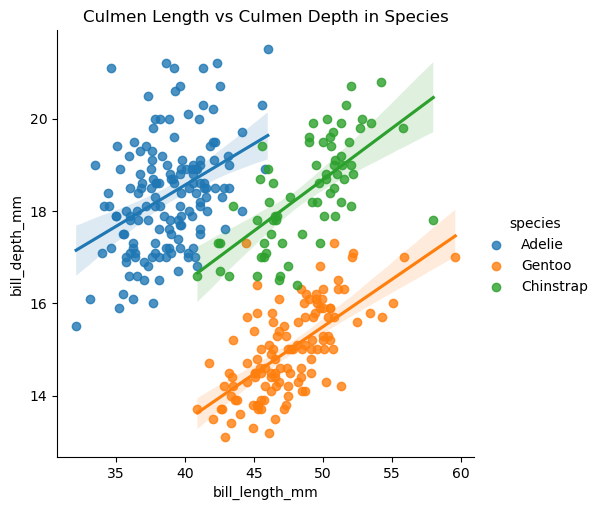

In [4]:
# Create a scatterplot of bill length vs bill depth using seaborn, hue by species. 
# Add a title.
sns.lmplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species").set(title="Culmen Length vs Culmen Depth in Species")
plt.show()

In [5]:
numeric_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',	'body_mass_g']
categorical_features = ['island', 'sex']

In [6]:
# create a pipeline to impute missing values with the mean and scale numeric features
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="mean")),
    ("scale", StandardScaler())
])
# create a pipeline to impute missing values with the most frequent value and one-hot encode categorical features
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder())
])

# create a column transformer to apply the numeric and categorical pipelines to the correct features
# use remainder='passthrough' to keep the remaining features in the dataframe
preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_features),
    ("cat", cat_pipeline, categorical_features)], 
    remainder="passthrough")

# fit_transform the preprocessor on the penguins dataset
# convert the result to a dataframe
# use the preprocessor's get_feature_names_out() method to get the column names
penguins_prepared = preprocessor.fit_transform(penguins)
df_penguins_prepared = pd.DataFrame(penguins_prepared, columns=preprocessor.get_feature_names_out())

# display the first 5 rows of the preprocessed dataframe
df_penguins_prepared.head()

,num__bill_length_mm,num__bill_depth_mm,num__flipper_length_mm,num__body_mass_g,cat__island_Biscoe,cat__island_Dream,cat__island_Torgersen,cat__sex_female,cat__sex_male,remainder__species
0,-0.887081,0.787743,-1.422488,-0.565789,0.0,0.0,1.0,0.0,1.0,Adelie
1,-0.813494,0.126556,-1.065352,-0.503168,0.0,0.0,1.0,1.0,0.0,Adelie
2,-0.66632,0.431719,-0.422507,-1.192003,0.0,0.0,1.0,1.0,0.0,Adelie
3,-0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Adelie
4,-1.328605,1.092905,-0.565361,-0.941517,0.0,0.0,1.0,1.0,0.0,Adelie


In [7]:
# separate the features from the target
# call the features X and the target y
X = df_penguins_prepared.drop("remainder__species", axis=1)
X_train, X_test = X[:275], X[275:]
y = df_penguins_prepared["remainder__species"]
y_train, y_test = y[:275], y[275:]

In [8]:
# setup binary classification for Adelie vs. rest of species
# use the Adelie species as the positive class
# create a new target called y_adelie
y_train_adelie = (y_train == "Adelie")
y_test_adelie = (y_test == "Adelie")

In [9]:
# build an SGDClassifier model using X and y
# use random_state=42 for reproducibility
SGDclass = SGDClassifier(random_state=42)
SGDclass.fit(X_train, y_train_adelie)

SGDClassifier(random_state=42)

In [10]:
# compute the accuracy using cross_val_score with cv=10
acc_score = cross_val_score(SGDclass, X_train, y_train_adelie, cv=10, scoring="accuracy")
acc_score

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.96296296, 1.        , 0.96296296])

In [11]:
# compute the mean accuracy
np.mean(acc_score)

0.9925925925925926

In [12]:
# predict the target using cross_val_predict with cv=10
# call the result y_train_pred
y_train_pred = cross_val_predict(SGDclass, X_train, y_train_adelie, cv=10)
y_train_pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [13]:
# compute the confusion matrix
con_matrix = confusion_matrix(y_train_adelie, y_train_pred)
con_matrix

array([[122,   1],
       [  1, 151]])

In [14]:
# compute the precision score using precision_score()
precision_score(y_train_adelie, y_train_pred)

0.993421052631579

In [15]:
# compute the recall score using recall_score()
recall_score(y_train_adelie, y_train_pred)

0.993421052631579

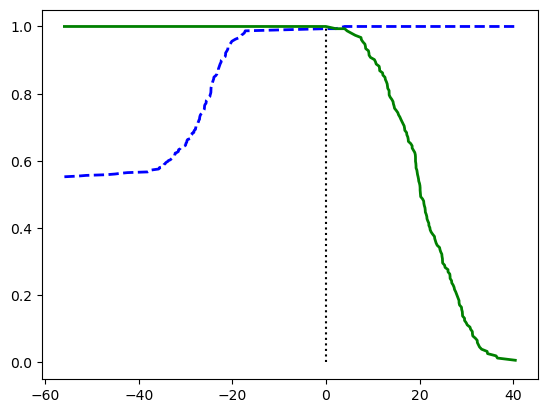

(array([0.55272727, 0.55474453, 0.55677656, 0.55882353, 0.56088561,
        0.56296296, 0.56505576, 0.56716418, 0.56928839, 0.57142857,
        0.57358491, 0.57575758, 0.57794677, 0.58015267, 0.58237548,
        0.58461538, 0.58687259, 0.58914729, 0.59143969, 0.59375   ,
        0.59607843, 0.5984252 , 0.60079051, 0.6031746 , 0.60557769,
        0.608     , 0.61044177, 0.61290323, 0.61538462, 0.61788618,
        0.62040816, 0.62295082, 0.6255144 , 0.62809917, 0.63070539,
        0.63333333, 0.63598326, 0.63865546, 0.64135021, 0.6440678 ,
        0.64680851, 0.64957265, 0.65236052, 0.65517241, 0.65800866,
        0.66086957, 0.66375546, 0.66666667, 0.66960352, 0.67256637,
        0.67555556, 0.67857143, 0.68161435, 0.68468468, 0.68778281,
        0.69090909, 0.69406393, 0.69724771, 0.70046083, 0.7037037 ,
        0.70697674, 0.71028037, 0.71361502, 0.71698113, 0.72037915,
        0.72380952, 0.72727273, 0.73076923, 0.73429952, 0.73786408,
        0.74146341, 0.74509804, 0.74876847, 0.75

In [16]:
# draw the precision-recall curve
# call the result precisions, recalls, thresholds
y_train_score = cross_val_predict(SGDclass, X_train, y_train_adelie, cv=10, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_adelie, y_train_score)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(0, 0, 1.0, "k", "dotted", label="threshold")
plt.show()
precisions, recalls, thresholds

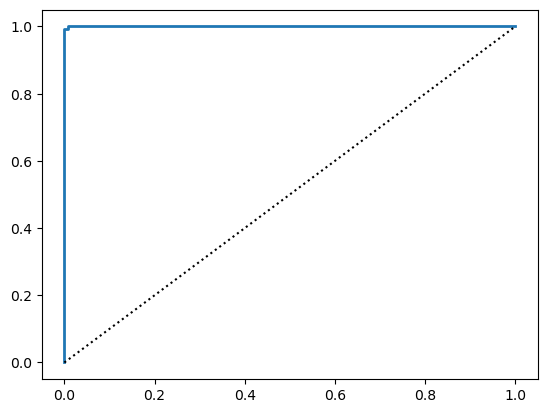

In [17]:
# call the result fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_train_adelie, y_train_score)
fpr, tpr, thresholds
# plot the roc curve
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0,1], [0,1], "k:", label="Random classifier's ROC curve")
plt.show()

In [18]:
# now let's do multiclass classification
# build an SGDClassifier model using X and y
# use random_state=42 for reproducibility
multi_cls = SGDClassifier(random_state=42)
multi_cls.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [19]:
# show the mean accuracy using cross_val_score with cv=10
np.mean(cross_val_score(multi_cls, X_train, y_train, cv=10, scoring="accuracy"))


0.9925925925925926

In [20]:
# predict the target using cross_val_predict with cv=10
# call the result y_train_pred
# show the confusion matrix
y_train_pred = cross_val_predict(multi_cls, X_train, y_train, cv=10)
y_train_pred
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[151,   1],
       [  1, 122]])

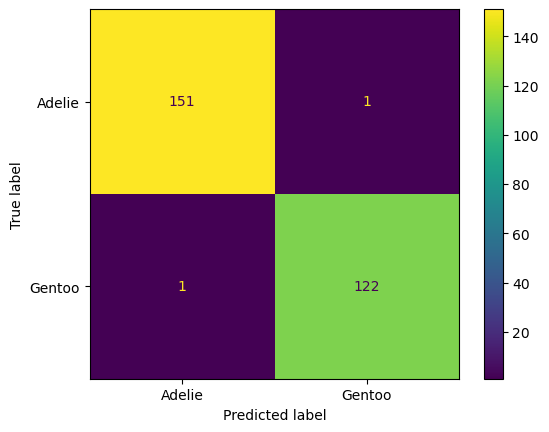

In [21]:
# use ConfusionMatrixDisplay to display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()
